<a href="https://colab.research.google.com/github/Soomro2023/Project5/blob/main/Weekly_trading_CAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
upload = files.upload()

Saving 2020Q1Q2Q3Q4-2021Q1.xlsx to 2020Q1Q2Q3Q4-2021Q1.xlsx


In [2]:
#dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import pmdarima as pm
# from prophet import Prophet
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping, ModelCheckpoint
# import os
# from pathlib import Path
# import requests
# import math
# from termcolor import colored as cl
import warnings
warnings.filterwarnings('ignore')

#read excel file
df  = pd.ExcelFile('2020Q1Q2Q3Q4-2021Q1.xlsx')

In [3]:
df = df.parse(5)  # read the Sberbank sheet
data_name = 'CAS'

In [4]:
df.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,5150,5100,5170,5100,212.44K,0.0098
1,2021-03-30 00:00:00,5100,5010,5100,5010,583.70K,0.0109
2,2021-03-29 00:00:00,5045,5020,5045,5015,117.54K,0.0050
3,2021-03-26 00:00:00,5020,5085,5085,4980,203.46K,-0.0020
4,2021-03-25 00:00:00,5030,5035,5045,4950,317.06K,0.0010


In [5]:
df.tail(5)

,Date,Price,Open,High,Low,Vol.,Change %
299,2020-01-08 00:00:00,6880,6940,6950,6880,84.93K,-0.0101
300,2020-01-07 00:00:00,6950,6950,6950,6850,168.71K,-0.0071
301,2020-01-03 00:00:00,7000,7040,7100,6960,470.77K,-0.0169
302,2020-01-02 00:00:00,7120,7300,7300,7120,138.96K,-0.0247
303,"Highest: 7,300.0","Lowest: 2,415.0","Difference: 4,885.0","Average: 4,836.5",Change %: -29.5,NaN,NaN


In [6]:
df = df[:-1] #deleting the last row as it is just providing statistics
df = df[::-1] #sorting the order so that 2020 appears first
df = df.reset_index()

#dropping volume and change % as they will not be used for the prediction
df = df.drop(columns = ['Vol.', 'Change %'])

#checking for null values
null_values = df.isnull().values.any()
if null_values:
    df = df.dropna(axis=0)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   303 non-null    int64 
 1   Date    303 non-null    object
 2   Price   303 non-null    object
 3   Open    303 non-null    object
 4   High    303 non-null    object
 5   Low     303 non-null    object
dtypes: int64(1), object(5)
memory usage: 14.3+ KB


In [8]:
#removing comma
df['Price'] = df['Price'].astype(str).str.extract(r'([^,]+)')
df['Open'] = df['Open'].astype(str).str.extract(r'([^,]+)')
df['High'] = df['High'].astype(str).str.extract(r'([^,]+)')
df['Low'] =  df['Low'].astype(str).str.extract(r'([^,]+)')

#changing dtype of columns to float
df['Price'] = pd.to_numeric(df['Price'])
df['Open'] = pd.to_numeric(df['Open'])
df['High'] = pd.to_numeric(df['High'])
df['Low'] = pd.to_numeric(df['Low'])

In [9]:
df.describe()

,index,Price,Open,High,Low
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,151.000000,4836.544554,4849.643564,4917.339934,4770.336634
std,87.612784,1025.407096,1026.688545,1014.299439,1029.420562
min,0.000000,2420.000000,2500.000000,2600.000000,2415.000000
25%,75.500000,3900.000000,3895.000000,3970.000000,3797.500000
50%,151.000000,4801.000000,4800.000000,4870.000000,4774.000000
75%,226.500000,5770.000000,5760.000000,5845.000000,5700.000000
max,302.000000,7120.000000,7300.000000,7300.000000,7120.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   303 non-null    int64 
 1   Date    303 non-null    object
 2   Price   303 non-null    int64 
 3   Open    303 non-null    int64 
 4   High    303 non-null    int64 
 5   Low     303 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 14.3+ KB


In [11]:
# date_arr = df['Date'].to_numpy() #storing date as we would need this at a later point

# #goal here is to split the data into train and test dataframe using end of 2020 as the boundary to slice the dataframe
# #finding the train-test boundary
# df['Year'] = pd.DatetimeIndex(df['Date']).year
# train_test_boundary = df[df['Year'] == 2020].index[-1] #extracting the index of where 2020 data finishes

# #setting date as index
# df = df.set_index('Date')

# df = df.drop(columns = 'index')

# #removing the Year column
# df = df.drop(columns = ['Year'])

# #normalize the data
# scaler = MinMaxScaler()
# cols = df.columns
# df[cols] = scaler.fit_transform(df[cols])

# #defining the training dataframe
# train_df = df[:train_test_boundary+1]

# #defining the testing dataframe
# test_df = df[train_test_boundary+1:]

#converting the date to Timestamp format
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

#splitting the dataframe into training and test dataset
df['year'] = df['Date'].dt.year
df_train = df[df['year'] == 2020]
df_test = df[df['year'] == 2021]

#getting the weekly closing price from training and test dataframe
price_train = []
date_train = []
price_test = []
date_test = []

for key,item in df.groupby(df_train.Date.dt.strftime('%W')):
    price_train.append(item['Price'].iloc[-1])
    date_train.append(item['Date'].iloc[-1])

for key,item in df.groupby(df_test.Date.dt.strftime('%W')):
    price_test.append(item['Price'].iloc[-1])
    date_test.append(item['Date'].iloc[-1])

#creating the dataframe
df_weekly_train = pd.DataFrame(list(zip(date_train, price_train)), columns=['Date','Price'])
df_weekly_test = pd.DataFrame(list(zip(date_test, price_test)), columns=['Date','Price'])

#goal here is to split the data into train and test dataframe using end of 2020 as the boundary to slice the dataframe
#finding the train-test boundary
df = pd.concat([df_weekly_train, df_weekly_test])
df['Year'] = pd.DatetimeIndex(df['Date']).year
train_test_boundary = df[df['Year'] == 2020].index[-1] #extracting the index of where 2020 data finishes

date_arr = df['Date'].to_numpy() #storing date as we would need this at a later point

#setting date as index
df = df.set_index('Date')

#removing the Year column
df = df.drop(columns = ['Year'])

#normalize the data
scaler = MinMaxScaler()
cols = df.columns
df[cols] = scaler.fit_transform(df[cols])

#defining the training dataframe
train_df = df[:train_test_boundary+1]

#defining the testing dataframe
test_df = df[train_test_boundary+1:]



In [12]:
fig = make_subplots(rows=1, cols=1)

fig.add_trace(
    go.Scatter(x = train_df.index, y = train_df["Price"], name = 'Train'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x = test_df.index, y = test_df["Price"], name = 'Test'),
    row=1, col=1
)

fig.add_vline(x=test_df.index[0], line_width=3, line_dash="dash", line_color="green")

fig.update_layout(
    title="Train/Test Distribution",
    xaxis_title="Date",
    yaxis_title="Normalized Close Price Values",

)



In [13]:
n_steps = 1
n_features = 1

# split a univariate sequence into samples
# for example if we had a data such as [10, 20, 30, 40, 50]
# and if n_step was 3
# then feature will be [[10, 20, 30], [20, 30, 30]]
# and label will be [[40], [50]]
# logic of this approach can be found here - machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting
def split_sequence(data, n_steps):
    X, y = list(), list()
    for i in range(len(data)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(data)-1:
            break
        # gather input and output parts of the pattern
        seq_x_price = data['Price'].iloc[i:end_ix]
        seq_y = data['Price'].iloc[end_ix]
        x = np.empty((2,n_features))
        for idx in range(n_steps):
            x[idx, 0] = seq_x_price[idx]
        y.append(seq_y)
        X.append(x)
    return np.array(X), np.array(y)

ratio = len(train_df) * 0.9
X_val_df = train_df.iloc[int(ratio):]
X_train_df = train_df.iloc[:int(ratio)]

# multivariate_y_val = y_train.iloc[int(ratio):]
# multivariate_y_train = y_train.iloc[:int(ratio)]

#creating training set and labels with a n_step of 3
X_train, y_train = split_sequence(X_train_df, n_steps)

#creating training set and labels with a n_step of 3
X_val, y_val = split_sequence(X_val_df, n_steps)

#creating training set and labels with a n_step of 3
X_test, y_test = split_sequence(test_df, n_steps)

In [14]:
test_df.index

DatetimeIndex(['2021-01-08', '2021-01-15', '2021-01-22', '2021-01-29',
               '2021-02-05', '2021-02-12', '2021-02-19', '2021-02-26',
               '2021-03-05', '2021-03-12', '2021-03-19', '2021-03-26',
               '2021-03-31'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [15]:
# Set a seed value
seed_value= 12321

def actual_prediction_plot(actual, prediction, data_name, model_name):
    """
    param actual: is the real test price data.
    param prediction: the model prediction by using the actual test data.
    param data_name: used to naming the title figures.
    param model_name: to add the model with it's score to a dict
    This function will return Actual  VS. Predicted Price plot.
    """



    preds = pd.DataFrame()
    preds['Actual Price'], preds['Predicted Price'], preds['Date'] = actual, prediction, test_df.index[:-1]
    preds = preds.set_index('Date')
    ax = preds[['Actual Price', 'Predicted Price']].plot(figsize=(12,8),title = f'Actual Price VS. Predicted Price for {model_name}')
    ax.autoscale(axis='Date',tight=True)
    return preds

def find_mae(y_true, y_pred):
    """
    return the mean absolute error
    """
    return mean_absolute_error(y_true, y_pred)




def train_valid_loss(hist, data_name, model_name):
    """
    param hist: output from deep NN like LSTM, and it contains both train and val loss scores.
    param data_name: used to naming the title figures.
    This function will return Train VS. Valid Loss plot.
    """
    plt.figure(figsize=(16, 5))
    plt.plot(hist.history['loss'], label='Train loss', linewidth=1.5)
    plt.plot(hist.history['val_loss'], label='Valid loss', linewidth=1.5)
    plt.title(f'Train VS. Valid Loss for {model_name}', fontsize=20)
    plt.legend();

def LSTM(X_train, y_train, X_val, y_val, X_test, y_test, n_features, data_name):
    """
    This function will use the LSTM and return both of the model name as well as the mean square error score to
    add it later to dict.
    """
    # adjust the seeds
    tf.random.set_seed(seed_value)

    # because we will use the LSTM with one and later with multiple features we need to define the model name to save it.

    model_name = f"{data_name} Multivariate LSTM Model"

    # 1) Create the model
    model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=100, activation='relu', input_shape=(X_train.shape[1], n_features)),
    tf.keras.layers.Dense(units=1)])

    # 2) Compile the model
    model.compile(loss=tf.keras.metrics.mae, optimizer=tf.keras.optimizers.Adam())

    # 3) Fit the model
    callbacks = [
        EarlyStopping(monitor='val_loss', mode='min',patience=50),
        ModelCheckpoint(f'output/models/{model_name}.h5', verbose=0, save_best_only=True)]
    hist = model.fit(X_train, y_train, epochs =5000, batch_size=16, validation_data=(X_val, y_val), callbacks=[callbacks], verbose=0)

    # 4) plot the train and val loss scores
    train_valid_loss(hist, data_name, model_name)

    # 5) find the predictions
    predictions = model.predict(X_test)
    # predictions = np.roll(predictions, -1)
    # 6) find the mean square error score
    mae = find_mae(y_test, predictions)
    # 7) plot the actual vs. predicted price
    # actual_prediction_plot(y_test, predictions, data_name, model_name)


    return model_name, mae, predictions

def scores(scores_dict):
    return pd.DataFrame(scores_dict)



def multivariate_LSTM(data_name, X_train, y_train, X_val, y_val, X_test, y_test, scores_dict):
    """
    return the multivariate LSTM moled result
    """



    multivariate_LSTM_X_train, multivariate_LSTM_y_train =  X_train, y_train
    multivariate_LSTM_X_val, multivariate_LSTM_y_val =  X_val, y_val
    multivariate_LSTM_X_test, multivariate_LSTM_y_test =  X_test, y_test

    multivariate_LSTM_model_name, multivariate_LSTM_model_mae, multivariate_LSTM_y_pred = LSTM(multivariate_LSTM_X_test, multivariate_LSTM_y_test, multivariate_LSTM_X_val, multivariate_LSTM_y_val, multivariate_LSTM_X_test, multivariate_LSTM_y_test, 1, data_name)
    scores_dict['Model'].append(multivariate_LSTM_model_name)
    scores_dict['Test Score'].append(multivariate_LSTM_model_mae)

    return multivariate_LSTM_model_name, multivariate_LSTM_y_pred

def models_report(X_train, y_train, X_val, y_val, X_test, y_test, data_name):


    #Create a scoring data frame and functiont to add score
    scores_dict = {"Model":[],"Test Score":[]}

    multivariate_LSTM_model_name, multivariate_LSTM_y_pred = multivariate_LSTM(data_name, X_train, y_train, X_val, y_val, X_test, y_test, scores_dict)


    return scores_dict, multivariate_LSTM_model_name, multivariate_LSTM_y_pred

1/1 [==============================] - 0s 227ms/step


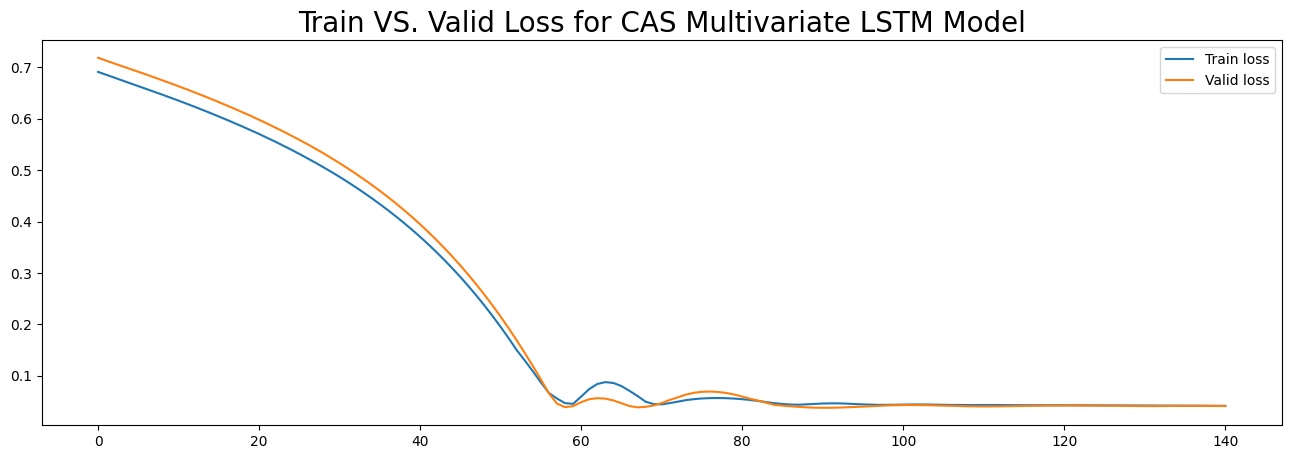

In [16]:
score, model_name, predictions = models_report(X_train, y_train, X_val, y_val, X_test, y_test, data_name)

In [17]:
score['Test Score']

[0.041746478566417]

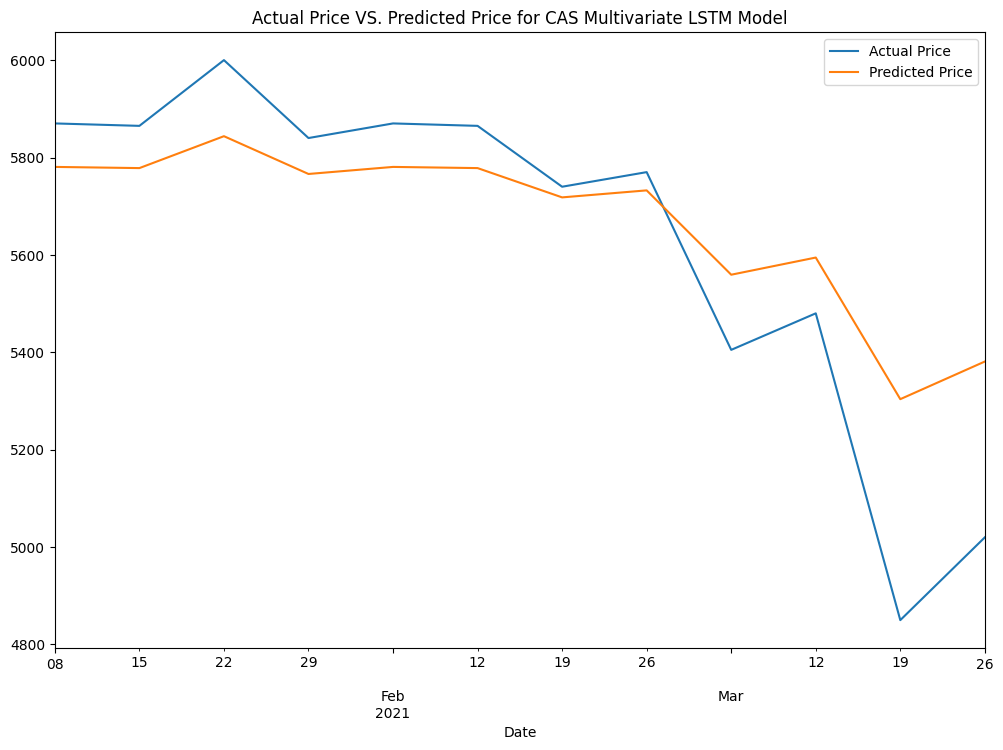

In [18]:
preds = np.append(predictions, np.zeros((predictions[:, 0].shape[0], 3)), axis=1)
preds = scaler.inverse_transform(preds)[:,0]
actual = scaler.inverse_transform(test_df)[:-1,0]
df_final = actual_prediction_plot(actual, preds, 'Sberbank', model_name)

In [19]:
df_final

,Actual Price,Predicted Price
Date,,
2021-01-08,5870.0,5780.686557
2021-01-15,5865.0,5778.270423
2021-01-22,6000.0,5843.785793
2021-01-29,5840.0,5766.201019
2021-02-05,5870.0,5780.686557
2021-02-12,5865.0,5778.270423
2021-02-19,5740.0,5718.119472
2021-02-26,5770.0,5732.511133
2021-03-05,5405.0,5559.314460


In [20]:
#bollinger bands calculation
def sma(data, window):
    sma = data.rolling(window = window).mean()
    return sma

def bb(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0

    for i in range(1, len(data)):
        if data.iloc[i-1] > lower_bb.iloc[i-1] and data.iloc[i] < lower_bb.iloc[i]:
            if signal != 1:
                buy_price.append(data.iloc[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data.iloc[i-1] < upper_bb.iloc[i-1] and data.iloc[i] > upper_bb.iloc[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data.iloc[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)

    return buy_price, sell_price, bb_signal

In [21]:
investment_returns = []
sma_params = []
bb_params = []

for sma_param in np.linspace(5, 50, 10).astype(int):
    df_final['sma'] = sma(df_final['Predicted Price'], sma_param)
    for bb_param in np.linspace(5, 50, 10).astype(int):
        df_final['upper_bb'], df_final['lower_bb'] = bb(df_final['Predicted Price'], df_final['sma'], bb_param)
        buy_price, sell_price, bb_signal = implement_bb_strategy(df_final['Predicted Price'], df_final['lower_bb'], df_final['upper_bb'])
        buy_price.insert(0, np.nan)
        sell_price.insert(0, np.nan)
        bb_signal.insert(0, np.nan)

        position = []
        for i in range(len(bb_signal)):
            if bb_signal[i] == np.nan:
                position.append(np.nan)
                continue
            if bb_signal[i] > 1:
                position.append(0)
            else:
                position.append(1)

        for i in range(len(df_final['Predicted Price'])):
            if bb_signal[i] == np.nan:
                continue
            if bb_signal[i] == 1:
                position[i] = 1
            elif bb_signal[i] == -1:
                position[i] = 0
            else:
                position[i] = position[i-1]

        upper_bb = df_final['upper_bb']
        lower_bb = df_final['lower_bb']
        close_price = df_final['Predicted Price']
        bb_signal = pd.DataFrame(bb_signal).rename(columns = {0:'bb_signal'}).set_index(df_final.index)
        position = pd.DataFrame(position).rename(columns = {0:'bb_position'}).set_index(df_final.index)

        frames = [close_price, upper_bb, lower_bb, bb_signal, position]
        strategy = pd.concat(frames, join = 'inner', axis = 1)

        #backtesting on actual price
        price_diff = np.diff(df_final['Actual Price'])
        list(price_diff).insert(0, None)
        df_final_ret = pd.DataFrame(price_diff).rename(columns = {0:'returns'})
        bb_strategy_ret = []

        for i in range(len(df_final_ret)):
            try:
                returns = df_final_ret['returns'][i]*strategy['bb_position'][i]
                bb_strategy_ret.append(returns)
            except:
                bb_strategy_ret.append(None)

        bb_strategy_ret.insert(0, None)
        bb_strategy_ret_df = pd.DataFrame(bb_strategy_ret).rename(columns = {0:'bb_returns'})
        bb_strategy_ret_df

        investment = 100000
        stocks = 0

        for i in range(len(bb_strategy_ret_df['bb_returns'])):
            if strategy['bb_signal'].iloc[i] == None:
                continue
            if strategy['bb_signal'].iloc[i] == 1:
                stocks = int(investment/df_final['Actual Price'].iloc[i])
            returns = stocks * bb_strategy_ret_df['bb_returns'].iloc[i]
            if str(returns) != 'nan':
                investment = investment + returns
        investment_returns.append(investment - 100000)
        sma_params.append(sma_param)
        bb_params.append(bb_param)

max_idx = np.argmax(np.array(investment_returns))
print("Highest return is ${} with sma of {} using a bollinger parameter {}".
      format(investment_returns[max_idx], sma_params[max_idx], bb_params[max_idx]))

Highest return is $0.0 with sma of 5 using a bollinger parameter 5


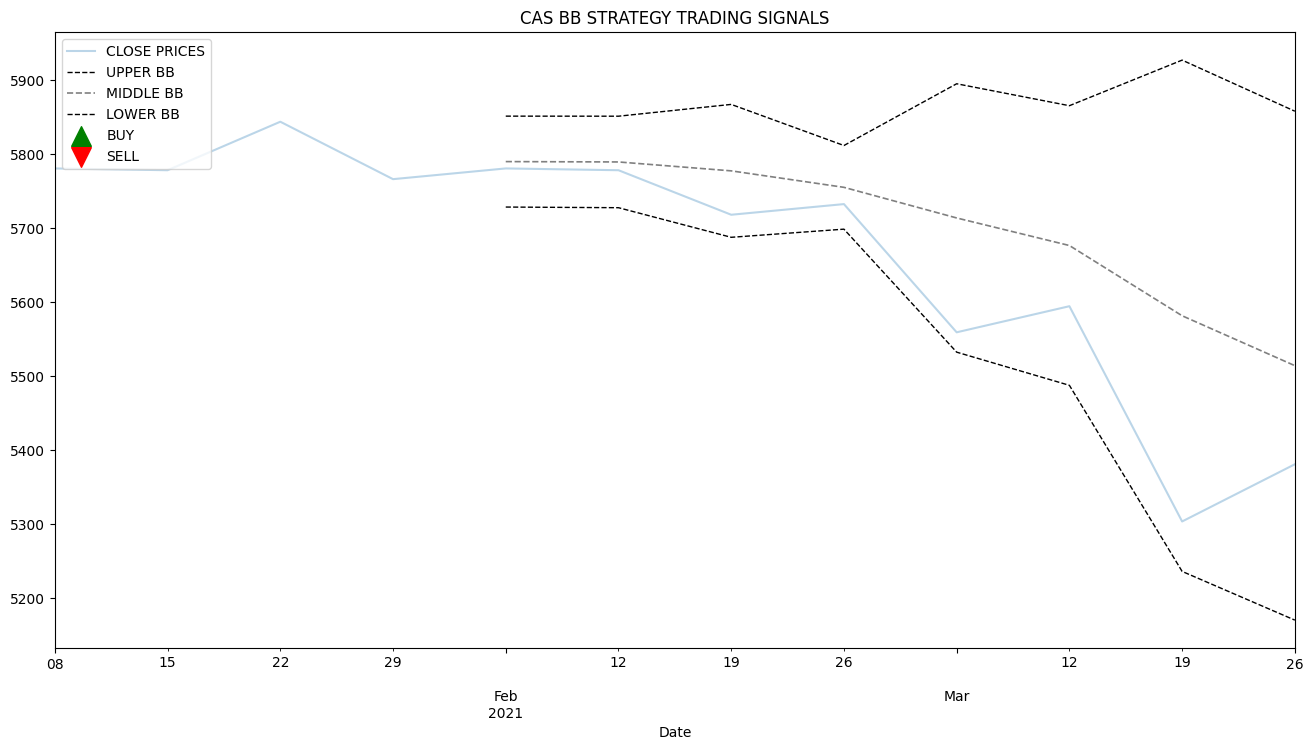

In [22]:
df_final['sma'] = sma(df_final['Predicted Price'], 5)
df_final['upper_bb'], df_final['lower_bb'] = bb(df_final['Predicted Price'], df_final['sma'], 5)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_final['Predicted Price'], df_final['lower_bb'], df_final['upper_bb'])
buy_price.insert(0, None)
sell_price.insert(0, None)
bb_signal.insert(0, None)

plt.figure(figsize=(16, 8))
df_final['Predicted Price'].plot(label = 'CLOSE PRICES', alpha = 0.3)
df_final['upper_bb'].plot(label = 'UPPER BB', linestyle = '--', linewidth = 1, color = 'black')
df_final['sma'].plot(label = 'MIDDLE BB', linestyle = '--', linewidth = 1.2, color = 'grey')
df_final['lower_bb'].plot(label = 'LOWER BB', linestyle = '--', linewidth = 1, color = 'black')

plt.scatter(df_final.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
plt.scatter(df_final.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.title('{} BB STRATEGY TRADING SIGNALS'.format(data_name))
plt.legend(loc = 'upper left')
plt.show()